In [34]:
import torch
import torchvision
import time


In [35]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [36]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [37]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [38]:
example_data.shape

torch.Size([1000, 1, 28, 28])

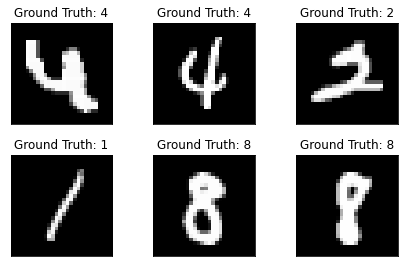

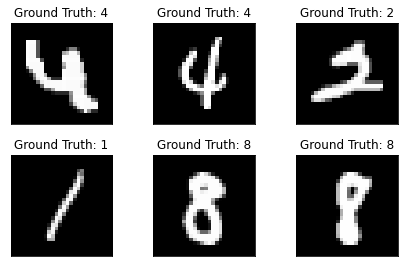

In [39]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [40]:
import torch.nn.functional as F
cuda0 = torch.device('cuda:0')
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return F.log_softmax(y_pred)

In [41]:
import torch.optim as optim
import torch.nn as nn
import os
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 28*28, 100, 10

# Create random Tensors to hold inputs and outputs

# Construct our model by instantiating the class defined above
def trainCuda(epoch, modelCuda, optimizerCuda, train_losses, train_counter):
  modelCuda.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizerCuda.zero_grad()
    data = torch.reshape(data, (data.shape[0], D_in)).cuda()
    target = target.cuda()
    output = modelCuda(data).cuda()
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizerCuda.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(modelCuda.state_dict(), 'model.pth')
      torch.save(optimizerCuda.state_dict(), 'optimizer.pth')
def testCuda(modelCuda, test_losses):
  modelCuda.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = torch.reshape(data, (data.shape[0], D_in)).cuda()
      target = target.cuda()
      data = data.cuda()
      output = modelCuda(data).cuda()
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [42]:

def train(epoch, model, optimizer, train_losses, train_counter):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = torch.reshape(data, (data.shape[0], D_in))
    target = target
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

def test(model, test_losses):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = torch.reshape(data, (data.shape[0], D_in))
      target = target
      data = data
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [43]:
def evalNormal(sizeH):
    if os.path.exists("model.pth"):
        os.remove("model.pth")
    if os.path.exists("optimizer.pth"):
        os.remove("optimizer.pth")
    model = TwoLayerNet(D_in, sizeH, D_out)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    start = time.time()
    test(model, test_losses)
    for epoch in range(1, n_epochs + 1):
        train(epoch, model, optimizer, train_losses, train_counter)
        test(model, test_losses)
    end = time.time()
    print("Normal time: " + str(end - start))
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig

<ipython-input-40-733c2f99c62e>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y_pred)
C:\Users\jomer\anaconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

Test set: Avg. loss: 2.3409, Accuracy: 1008/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.381538
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.068284
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.724548
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.511983
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.257360
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.019565
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.894276
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.714037
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.876823
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.582357
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.588537
Train Epoch: 1 [704

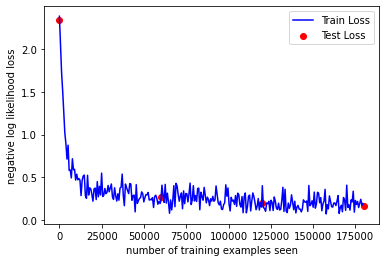

In [44]:
evalNormal(100)

<ipython-input-40-733c2f99c62e>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y_pred)

Test set: Avg. loss: 2.3563, Accuracy: 695/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.362654
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.064939
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.786643
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.485492
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.309162
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.108954
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.979450
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.941670
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.859612
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.682169
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.580330
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.689998
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.626746
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.400621
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.482138
Train Epoch: 1 [9600/60000 (16

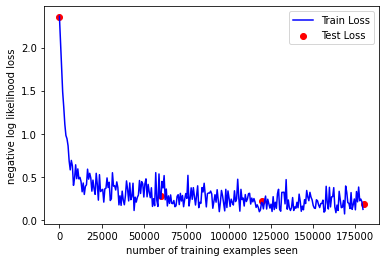

In [45]:
evalNormal(50)

<ipython-input-40-733c2f99c62e>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y_pred)

Test set: Avg. loss: 2.3320, Accuracy: 1107/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317698
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.905283
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.433548
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.092710
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.846451
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.843853
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.914032
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.952129
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.464962
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.578621
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.579404
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.717827
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.535334
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.463105
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.446245
Train Epoch: 1 [9600/60000 (

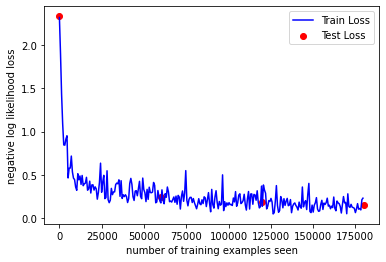

In [46]:
evalNormal(1000)

In [47]:
def evalNormalCuda(sizeH):
    if os.path.exists("model.pth"):
        os.remove("model.pth")
    if os.path.exists("optimizer.pth"):
        os.remove("optimizer.pth")
    model = TwoLayerNet(D_in, sizeH, D_out).cuda()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    start = time.time()
    testCuda(model, test_losses)
    for epoch in range(1, n_epochs + 1):
        trainCuda(epoch, model, optimizer, train_losses, train_counter)
        testCuda(model, test_losses)
    end = time.time()
    print("Normal time cuda: " + str(end - start))
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig

<ipython-input-40-733c2f99c62e>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y_pred)

Test set: Avg. loss: 2.3283, Accuracy: 1179/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.337443
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.100049
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.770795
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.595631
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.191815
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.185881
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.951981
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.838880
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.833406
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.588160
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.601503
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.665740
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.659418
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.567357
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.470925
Train Epoch: 1 [9600/60000 (

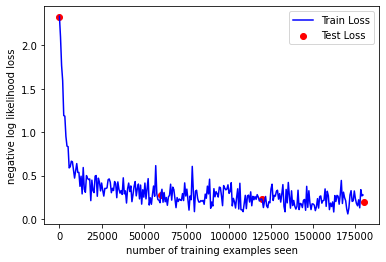

In [48]:
evalNormalCuda(50)

<ipython-input-40-733c2f99c62e>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y_pred)

Test set: Avg. loss: 2.3003, Accuracy: 1337/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323813
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.003952
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.708217
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.522207
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.202521
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.007565
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.860654
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.846779
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.740486
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.681168
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.755719
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.482623
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.540582
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.440732
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.434193
Train Epoch: 1 [9600/60000 (

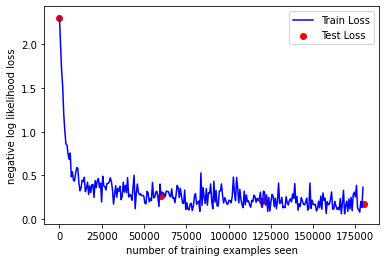

In [49]:
evalNormalCuda(100)

<ipython-input-40-733c2f99c62e>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y_pred)

Test set: Avg. loss: 2.3206, Accuracy: 882/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322517
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.917023
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.447885
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.206582
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.987944
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.828916
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.848593
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.722259
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.611337
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.585875
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.478657
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.532396
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.545132
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.447654
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.456869
Train Epoch: 1 [9600/60000 (16

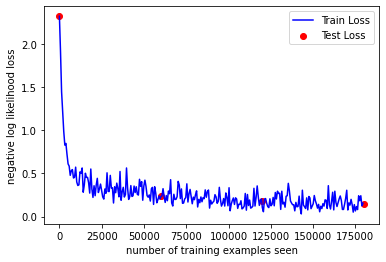

In [50]:
evalNormalCuda(1000)

In [65]:
import torch.nn.functional as F
cuda0 = torch.device('cuda:0')
class TwoLayerNetCE(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNetCE, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

In [66]:

def trainCE(epoch, model, optimizer, train_losses, train_counter):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = torch.reshape(data, (data.shape[0], D_in))
    target = target
    output = model(data)
    crossEntropy = nn.CrossEntropyLoss()
    loss = crossEntropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

def testCE(model, test_losses):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = torch.reshape(data, (data.shape[0], D_in))
      target = target
      data = data
      output = model(data)
      crossEntropy = nn.CrossEntropyLoss(size_average=False)
      test_loss += crossEntropy(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [67]:
def evalNormalCE(sizeH):
    if os.path.exists("model.pth"):
        os.remove("model.pth")
    if os.path.exists("optimizer.pth"):
        os.remove("optimizer.pth")
    model = TwoLayerNetCE(D_in, sizeH, D_out)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    start = time.time()
    testCE(model, test_losses)
    for epoch in range(1, n_epochs + 1):
        trainCE(epoch, model, optimizer, train_losses, train_counter)
        testCE(model, test_losses)
    end = time.time()
    print("Normal time: " + str(end - start))
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig


Test set: Avg. loss: 2.3323, Accuracy: 1001/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326583
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.022471
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.750720
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.366381
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.365376
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.982065
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.977696
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.877156
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.740780
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.637262
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.615371
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.551552
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.578284
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.544127
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.492356
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.451594
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.633568
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.522559
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.542718
Train Epoch: 1 [12160

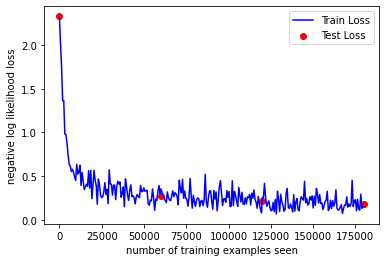

In [68]:
evalNormalCE(50)


Test set: Avg. loss: 2.3360, Accuracy: 833/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.338766
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.048552
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.771683
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.472915
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.202364
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.972789
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.145361
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.810688
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.803720
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.695582
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.731500
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.543007
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.520223
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.417066
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.659479
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.601624
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.528218
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.665070
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.559927
Train Epoch: 1 [12160/6

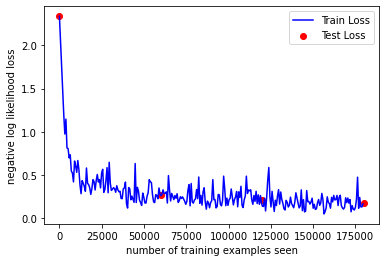

In [69]:
evalNormalCE(100)


Test set: Avg. loss: 2.3204, Accuracy: 1203/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.337541
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.868805
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.536868
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.294830
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.063329
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.940686
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.794419
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.624039
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.536509
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.624713
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.447321
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.471848
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.499001
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.522987
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.444209
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.327952
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.458914
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.506577
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.378121
Train Epoch: 1 [12160

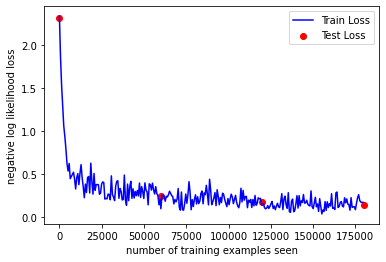

In [70]:
evalNormalCE(1000)

In [76]:
def trainCudaCE(epoch, modelCuda, optimizerCuda, train_losses, train_counter):
  modelCuda.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizerCuda.zero_grad()
    data = torch.reshape(data, (data.shape[0], D_in)).cuda()
    target = target.cuda()
    output = modelCuda(data).cuda()
    crossEntropy = nn.CrossEntropyLoss()
    loss = crossEntropy(output, target)
    loss.backward()
    optimizerCuda.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(modelCuda.state_dict(), 'model.pth')
      torch.save(optimizerCuda.state_dict(), 'optimizer.pth')
def testCudaCE(modelCuda, test_losses):
  modelCuda.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = torch.reshape(data, (data.shape[0], D_in)).cuda()
      target = target.cuda()
      data = data.cuda()
      output = modelCuda(data).cuda()
      crossEntropy = nn.CrossEntropyLoss(size_average=False)
      test_loss += crossEntropy(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [77]:
def evalCudaCE(sizeH):
    if os.path.exists("model.pth"):
        os.remove("model.pth")
    if os.path.exists("optimizer.pth"):
        os.remove("optimizer.pth")
    model = TwoLayerNetCE(D_in, sizeH, D_out).cuda()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    start = time.time()
    testCudaCE(model, test_losses)
    for epoch in range(1, n_epochs + 1):
        trainCudaCE(epoch, model, optimizer, train_losses, train_counter)
        testCudaCE(model, test_losses)
    end = time.time()
    print("Normal time cuda: " + str(end - start))
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig

C:\Users\jomer\anaconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

Test set: Avg. loss: 2.3211, Accuracy: 809/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.280140
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.125044
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.900214
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.601219
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.362761
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.267500
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.046679
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.817482
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.880026
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.732369
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.719543
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.602332
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.554029
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.575072
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.555795
Train Epoch: 1 [9

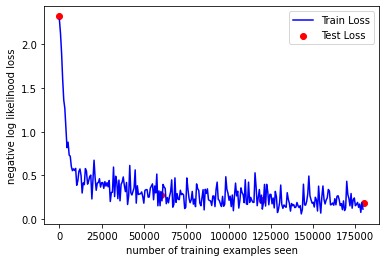

In [78]:
evalCudaCE(50)


Test set: Avg. loss: 2.2949, Accuracy: 1002/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330576
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.043931
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.726597
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.388082
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.121305
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.963630
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.917939
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.812991
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.677805
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.749079
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.520843
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.519866
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.471136
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.627456
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.569029
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.599599
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.460874
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.444468
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.340555
Train Epoch: 1 [12160

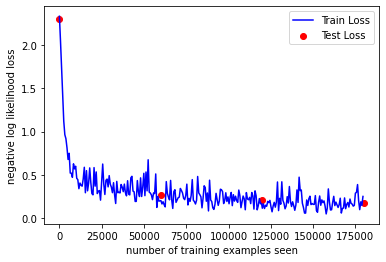

In [79]:
evalCudaCE(100)


Test set: Avg. loss: 2.3140, Accuracy: 1100/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.339088
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.849709
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.632956
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.171004
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.921932
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.721326
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.666523
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.673362
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.798969
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.644685
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.524891
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.686710
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.464145
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.390553
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.376947
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.397080
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.442575
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.555089
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.378853
Train Epoch: 1 [12160

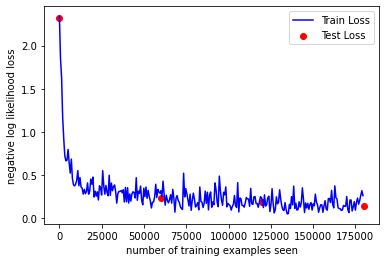

In [80]:
evalCudaCE(1000)